# HW01 -- kNN 葡萄酒分類

In [1]:
import csv
import math
import random
import operator
import sys
import matplotlib.pyplot as plt
import numpy as np
import time

random.seed()

**開啟資料檔**

利用 Python With open as 語法開啟 wine.data，避免忘記關檔發生錯誤。

原始的 wine.data 將分類放在第一欄，這不太符合一般習慣，因此將檔案重整，把分類放到最後一欄。

最後，設下一個標準值，並取一個亂數，若取得的亂數 > 標準值，則為 test data；否則為 training data。

In [2]:
def openData(filename, split, trainingData=[], testData = []):
    with open(filename, 'r') as csvData:
        lines = csv.reader(csvData)
        dataSet = list(lines)
        dataItems = len(dataSet[0]) -1
        
        # 讀入的 wine.data 分類結果在第一欄
        # 將資料重整，將分類結果移到最後一欄
        # data[x][0] - data[x][12] 為各項屬性的值
        # data[x][13] 是分類結果
        for x in range(len(dataSet)):
            tempValue = dataSet[x][0]
            for y in range(dataItems):
                dataSet[x][y] = float(dataSet[x][y+1])
            dataSet[x][-1] = tempValue
            
            # 利用亂數選取 training Data & testing Data
            if random.random() < split:
                trainingData.append(dataSet[x])
            else:
                testData.append(dataSet[x])

**進行標準化**

前面 openData() 函數未將資料標準化，最後的計算結果可能會受到某些數值較大的欄位嚴重影響，因此再建立一個會進行標準化的函數 openDataNormalization()，可比較標準化對於結果的影響。

標準化方式以下列公式進行：

*(X - Min) / (Max - Min)*

In [3]:
def openDataNormalization(filename, split, trainingData=[], testData = []):
    with open(filename, 'r') as csvData:
        lines = csv.reader(csvData)
        dataSet = list(lines)
        dataItems = len(dataSet[0]) -1
        
        for columns in range(1, len(dataSet[0])):
            minX = float(dataSet[0][columns])
            maxX = float(dataSet[0][columns])
            
            for x in range(len(dataSet)):
                dataSet[x][columns] = float(dataSet[x][columns])
                if dataSet[x][columns] <  minX:
                    minX = dataSet[x][columns]
                if dataSet[x][columns] >  maxX:
                    maxX = dataSet[x][columns]
            
            for findMin in range(len(dataSet)):
                dataSet[findMin][columns] = (dataSet[findMin][columns] - minX) / (maxX - minX)

        for x in range(len(dataSet)):
            tempValue = dataSet[x][0]
            for y in range(dataItems):
                dataSet[x][y] = dataSet[x][y+1]
            dataSet[x][-1] = tempValue
            
            # 利用亂數選取 training Data & testing Data
            if random.random() < split:
                trainingData.append(dataSet[x])
            else:
                testData.append(dataSet[x])

**計算每個點與其他點的距離**

利用歐氏距離公式計算每個點與其他點的距離。

In [4]:
def computingDistance(instance1, instance2, dataSetLength):
    distance = 0
    
    # 依照資料維度計算距離
    for x in range(dataSetLength):
        distance += pow((instance1[x] - instance2[x]), 2)
    return math.sqrt(distance)

**找出最近的鄰居**

利用 sort() 方法，對 distance 的第二個欄位進行排序，挑選排序最前的 K 個鄰居。

In [5]:
def getNeighbors(trainingData, testInstance, k):
    length = len(trainingData[0]) - 1
    sampleSize = len(trainingData)
    distance = []
    neighbors = []
    
    for x in range(sampleSize):
        dist = computingDistance(trainingData[x], testInstance, length)
        distance.append((trainingData[x], dist))
        
    distance.sort(key = lambda d: d[1], reverse = False)
    
    for x in range(k):
        neighbors.append(distance[x][0])
        
    return neighbors

**統計附近鄰居的類別**

找出距離最近的鄰居後，一一統計各個鄰居的類別，加入多數派中。

如果某些類別人數相同，**就隨意挑一個類別加入**。

In [6]:
def getResponse(neighbors):
    neighborsVotes = {}
    
    for x in range(len(neighbors)):
        response = neighbors[x][-1]
        
        if response in neighborsVotes:
            neighborsVotes[response] += 1
        else:
            neighborsVotes[response] = 1
        
    sortedVotes = sorted(neighborsVotes.items(), key= lambda d: d[1], reverse = True)
    
    return sortedVotes[0][0]

**計算正確率**

將預測的結果與真正的結果做比較，並計算預測的正確率。

In [7]:
def getAccuracy(testData, predictions):
    correct = 0
    
    for x in range(len(testData)):
        if testData[x][-1] == predictions[x]:
            correct += 1
    
    return (correct/float(len(testData))) * 100.0

**計算不同 k 值對正確率的影響**

k 值可能會影響正確率，因此從 k=3 到 k=15 分別計算其正確率。為減少誤差，每個 k 值情況都進行 20 次計算，再求其平均正確率。

最後依照 k 值與正確率的關係畫出折線圖。

In [8]:
def kNumbers(testTimes, normalization):
    kAffect = []
    note = ''
    fileName = ''
    
    for k in range(3,26):
        accuracy = 0
        split = 0.5
        
        for x in range(testTimes):
            trainingData=[]
            testData=[]
            if normalization == True:
                note = '\n With Data Normalization'
                fileName = '-WithNormalization'
                openDataNormalization('wine.data', split, trainingData, testData)
            else:
                note = '\n Without Data Normalization'
                fileName = '-WithoutNormalization'
                openData('wine.data', split, trainingData, testData)
        
            predictions=[]
            for y in range(len(testData)):
                neighbors = getNeighbors(trainingData, testData[y], k)
                result = getResponse(neighbors)
                predictions.append(result)
            
            accuracy += getAccuracy(testData, predictions)
    
        kAffect.append((k, accuracy/testTimes))
        
    kAffectNP = np.asarray(kAffect, dtype= {'names': ['x', 'y'], 'formats':['f8','f8']})
    minX = int(kAffect[0][1])
    maxX = int(kAffect[0][1])
    
    for i in range(5):
        if int(kAffect[i][1]) < minX:
            minX = int(kAffect[i][1])
        if int(kAffect[i][1]) > maxX:
            maxX = int(kAffect[i][1])
    minX = 5 * (int(minX / 5) - 3) # 為了畫圖好看，不會整個擠在一起
    maxX = 5 * (int(maxX / 5) + 3) # 所以上下各加 10
    
    plt.figure(figsize=(10, 5))
    plt.plot(kAffectNP['x'], kAffectNP['y'])
    plt.xlabel('k-Numbers')
    plt.ylabel('Accuracy (%)')
    plt.tick_params(axis='x', rotation=45)
    plt.title('k-Numbers V.S. Accuracy' + note)
    plt.xticks(np.arange(3, 26, 1))
    plt.yticks(np.arange(int(minX), int(maxX), 5))
    plt.savefig('K-numbers-VS-Accuracy' + fileName + '.png', transparent=True)

**計算不同 training data 的量對正確率的影響**

Training data 太多或太少都可能會影響正確率，因此分別計算 Training data 佔總量 30% 到 70% 的情況，其正確率的改變。

為減少誤差，每種情況都進行 20 次計算，再求其平均正確率，最後依照 training data 佔總數的比例與正確率的關係畫出折線圖。

In [9]:
def trainingSize(testTimes, normalization):
    trainingAffect = []
    note = ''
    fileName = ''
    
    for split in range(3,8):
        accuracy = 0
        k = 15
        split = split / 10
        
        for x in range(testTimes):
            trainingData=[]
            testData=[]
            if normalization == True:
                note = '\n With Data Normalization'
                fileName = '-Normalization'
                openDataNormalization('wine.data', split, trainingData, testData)
            else:
                note = '\n Without Data Normalization'
                fileName = '-WithoutNormalization'
                openData('wine.data', split, trainingData, testData)
        
            predictions=[]
            for y in range(len(testData)):
                neighbors = getNeighbors(trainingData, testData[y], k)
                result = getResponse(neighbors)
                predictions.append(result)
            
            accuracy += getAccuracy(testData, predictions)

        trainingAffect.append((split * 100.0, accuracy/testTimes))
    
    trainingAffectNP = np.asarray(trainingAffect, dtype= {'names': ['x', 'y'], 'formats':['f8','f8']})
    minX = int(trainingAffect[0][1])
    maxX = int(trainingAffect[0][1])
    
    for i in range(5):
        if int(trainingAffect[i][1]) < minX:
            minX = int(trainingAffect[i][1])
        if int(trainingAffect[i][1]) > maxX:
            maxX = int(trainingAffect[i][1])
    minX = 5 * (int(minX / 5) - 3) # 為了畫圖好看，不會整個擠在一起
    maxX = 5 * (int(maxX / 5) + 3) # 所以上下各加 10
    
    plt.figure(figsize=(10, 5))
    plt.plot(trainingAffectNP['x'], trainingAffectNP['y'])
    plt.xlabel('Training Data Size %')
    plt.ylabel('Accuracy (%)')
    plt.tick_params(axis='x', rotation=45)
    plt.title('Training Data Size V.S. Accuracy' + note )
    plt.xticks(np.arange(30, 80, 10))
    plt.yticks(np.arange(int(minX), int(maxX), 5))
    plt.savefig('Training-Size-VS-Accuracy' + fileName + '.png', transparent=True)

In [10]:
def main():
    testTimes = 20
    
    startTime = time.process_time()
    normalization = False
    kNumbers(testTimes, normalization)
    trainingSize(testTimes, normalization)
    endTime = time.process_time()
    print('本次測試共進行 ' + repr(endTime - startTime) + ' 秒')
    
    startTime = time.process_time()
    normalization = True
    kNumbers(testTimes, normalization)
    trainingSize(testTimes, normalization)
    endTime = time.process_time()
    print('本次測試共進行 ' + repr(endTime - startTime) + ' 秒')

本次測試共進行 40.515625 秒
本次測試共進行 42.09375 秒


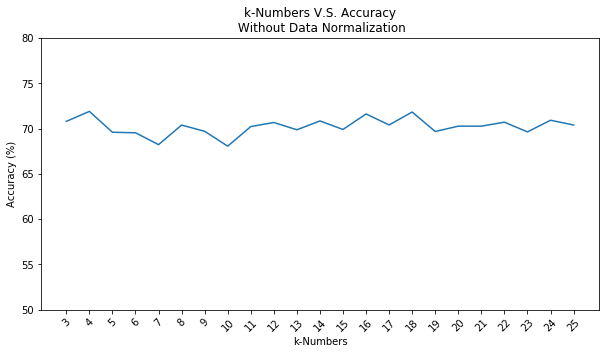

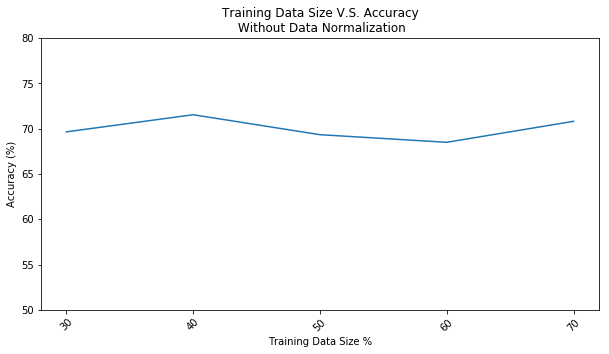

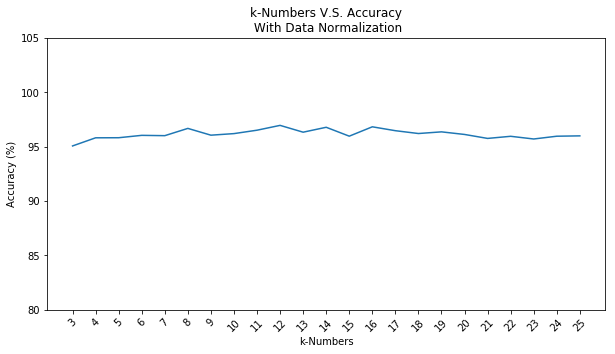

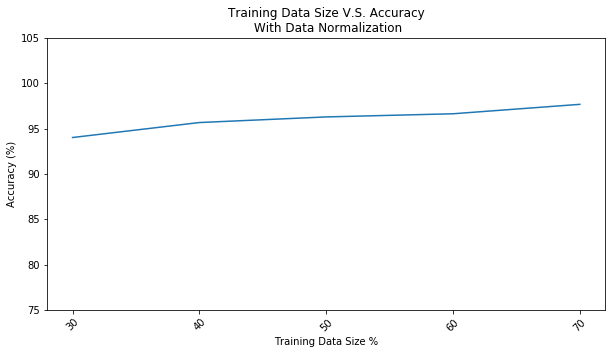

In [11]:
main()

## 實驗結果 ##

**未標準化資料的結果**

1. k 值對於葡萄酒預測的正確率影響不大，從 k=3 到 k=25，其預測正確率都在 68% ~ 72% 之間震盪，可知在葡萄酒的分類上選擇小一點的 k 值即可。
1. 同樣的，training data 大小對於正確率影響不大，不同 training data 大小，所得到的正確率都介於 68% ~ 72% 之間。

**將資料標準化的結果**

1. 將資料進行標準化後，無論 k=3 或 k=25，其正確率都超過 95%。逐漸增加 K 值，可讓正確率微幅上升，但效益不明顯。
1. 同樣的，將資料標準化後，隨著 training data size 的提昇，正確率也隨之穩定提昇。考慮到 30% 的 training data 都有 95% 的正確率，因此在標準化之後，可以將 training data size 調降，減少計算時間，但也還能得到不錯的結果。

## 結論 ##

從這次的實驗可以知道，影響結果最多的不是 k 值，也不是 training data size，而是**資料是否經過標準化**。

未經標準化的資料可能因為某些欄位數值過大而影響整體結果；一旦將資料進行標準化，讓每個欄位的影響程度相同，就比較不會讓單一欄位有過大的影響力。**因此在分類之前將資料進行標準化是很重要的步驟，不可省略標準化的過程。**